In [1]:
# Import Libraries
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
PATH_DATA = "../data/real_estate_image_type/"

In [4]:
!tar -xzf ../data/data.tar.gz -C ../data/

In [ ]:
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
from tqdm import tqdm_notebook

In [6]:
import random, os

In [7]:
train_set = datasets.ImageFolder("data/parsed/train/", transform = transformations )
valid_set = datasets.ImageFolder("data/parsed/valid/", transform = transformations)

In [11]:
t = 

In [15]:
import matplotlib.pyplot as plt

In [19]:
np.asarray(t)[0].shape

(224, 224)

In [22]:
np.asarray(train_set[1987][0])

array([[[ 1.8721637 ,  1.9064132 ,  1.923538  , ...,  0.5878072 ,
          0.33093593,  0.5193082 ],
        [ 1.8892884 ,  1.8721637 ,  1.8892884 , ...,  0.673431  ,
          0.673431  ,  0.63918144],
        [ 1.8892884 ,  1.8550389 ,  1.8379141 , ...,  0.5193082 ,
          0.63918144,  0.5364329 ],
        ...,
        [ 0.72480524,  0.5364329 ,  0.57068247, ...,  0.810429  ,
          0.79330426,  0.7590547 ],
        [ 1.2042983 ,  1.0844251 ,  0.96455175, ...,  0.96455175,
          0.9131775 ,  0.8446785 ],
        [ 1.1700488 ,  1.0673003 ,  0.9988013 , ...,  0.82755375,
          0.79330426,  0.74193   ]],

       [[ 2.0434172 ,  2.0784314 ,  2.0784314 , ...,  0.5203082 ,
          0.2226892 ,  0.3977592 ],
        [ 2.0609243 ,  2.0434172 ,  2.0434172 , ...,  0.62535024,
          0.57282925,  0.5203082 ],
        [ 2.0609243 ,  2.0084033 ,  1.9908963 , ...,  0.4677872 ,
          0.5378152 ,  0.4327732 ],
        ...,
        [ 0.4677872 ,  0.2401962 ,  0.2226892 , ...,  

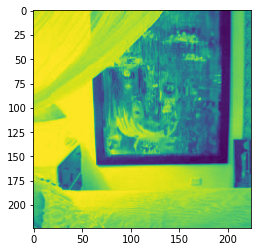

In [24]:
import numpy as np

plt.imshow(np.asarray(train_set[1987][0])[1])

In [7]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=32, shuffle=True)

In [9]:
model = models.densenet161(pretrained=True)
# Turn off training for their parameters
for param in model.parameters():
    param.requires_grad = False

/home/ubuntu/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [10]:
num_labels = len(train_set.classes)

In [11]:
class LinearClassifier(nn.Module):
    def __init__(self, in_feature_number, class_number):
        super(LinearClassifier, self).__init__()

        self.f1 = nn.Linear(in_feature_number, 256)
        self.f2 = nn.Linear(256, class_number)
        self.dropout = nn.Dropout(p=0.1)
        self.soft_max = nn.LogSoftmax(dim=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.f1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.f2(x)
        output = self.soft_max(x)
        return output

In [12]:
# Replace default classifier with new classifier
classifier_ = LinearClassifier(in_feature_number=model.classifier.in_features, class_number=num_labels)
model.classifier = classifier_

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move model to the device specified above
_ = model.to(device)

In [14]:
device

device(type='cuda')

In [15]:
criterion = nn.NLLLoss()
# Set the optimizer function using torch.optim as optim library
optimizer = optim.Adam(model.classifier.parameters())

In [16]:
PATH_CHECKPOINT = "./models/check_"

In [17]:
logger = Logger('./logs')

In [ ]:
epochs = 10
num_of_examples = 15000

for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    accuracy = 0
    
    # Training the model
    model.train()
    counter = 0
    print(f" -> TRAINING EPOCH {epoch}")
    for inputs, labels in tqdm_notebook(train_loader):
        # Move to device
        inputs, labels = inputs.to(device), labels.to(device)
        # Clear optimizers
        optimizer.zero_grad()
        # Forward pass
        output = model.forward(inputs)
        # Loss
        loss = criterion(output, labels)
        # Calculate gradients (backpropogation)
        loss.backward()
        # Adjust parameters based on gradients
        optimizer.step()
        # Add the loss to the training set's rnning loss
        train_loss += loss.item()*inputs.size(0)
        
        # Print the progress of our training

        counter += 1
        
        if counter >= num_of_examples:
            break
    
        
    # Evaluating the model
    model.eval()
    counter = 0
    # Tell torch not to calculate gradients
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH_CHECKPOINT + str(epoch) + ".pt")
    
    print(f"-> EVALUATING EPOCH {epoch}")

    with torch.no_grad():
        for inputs, labels in tqdm_notebook(valid_loader):
            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            output = model.forward(inputs)
            # Calculate Loss
            valloss = criterion(output, labels)
            # Add loss to the validation set's running loss
            val_loss += valloss.item()*inputs.size(0)
            
            # Since our model outputs a LogSoftmax, find the real 
            # percentages by reversing the log function
            output = torch.exp(output)
            # Get the top class of the output
            top_p, top_class = output.topk(1, dim=1)
            # See how many of the classes were correct?
            equals = top_class == labels.view(*top_class.shape)
            # Calculate the mean (get the accuracy for this batch)
            # and add it to the running accuracy for this epoch
            accuracy += torch.sum(equals.type(torch.FloatTensor)).item()
 
            
            # Print the progress of our evaluation
            counter += 1
            if counter >= num_of_examples:
                break
            
    # Get the average loss for the entire epoch
    train_loss = train_loss/(train_loader.batch_size*(counter))
    valid_loss = val_loss/(valid_loader.batch_size*(counter))
    # Print out the information
    acc = accuracy/(valid_loader.batch_size*counter)
    print('Accuracy: ', acc)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    logger.scalar_summary("accuracy",  acc, epoch+1)
    logger.scalar_summary("train_loss",  train_loss, epoch+1)
    logger.scalar_summary("valid_loss",  valid_loss, epoch+1)


 -> TRAINING EPOCH 0


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [22]:
criterion(output, labels)

tensor(-0.8451, device='cuda:0')

In [23]:
for image in valid_loader:
    print(image)
    break

[tensor([[[[ 0.3309,  0.3481,  0.3481,  ...,  0.5536,  0.5536,  0.5364],
          [ 0.3481,  0.3481,  0.3481,  ...,  0.5536,  0.5536,  0.5364],
          [ 0.3481,  0.3481,  0.3652,  ...,  0.5536,  0.5536,  0.5536],
          ...,
          [-0.3712, -0.2856, -0.2684,  ...,  0.1597,  0.1939,  0.1597],
          [-0.2684, -0.1657, -0.1143,  ...,  0.0056,  0.1768,  0.1768],
          [-0.2856, -0.3027, -0.3198,  ..., -0.0801, -0.0458, -0.0629]],

         [[ 0.2227,  0.2402,  0.2402,  ...,  0.3452,  0.3452,  0.3277],
          [ 0.2402,  0.2402,  0.2402,  ...,  0.3452,  0.3452,  0.3277],
          [ 0.2402,  0.2402,  0.2577,  ...,  0.3452,  0.3452,  0.3452],
          ...,
          [ 0.2052,  0.2927,  0.3102,  ...,  0.7479,  0.7829,  0.7479],
          [ 0.3102,  0.4153,  0.4678,  ...,  0.5903,  0.7654,  0.7654],
          [ 0.3102,  0.2927,  0.2752,  ...,  0.5203,  0.5553,  0.5378]],

         [[ 0.2522,  0.2696,  0.2696,  ...,  0.4091,  0.4091,  0.3916],
          [ 0.2696,  0.2696, 

In [24]:
PATH = "./model.pt"

torch.save(model, PATH)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type LinearClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [25]:
print('Accuracy: ', accuracy/(valid_loader.batch_size*counter))


Accuracy:  0.9148805715504372


In [26]:
for img in valid_loader:
    data, labels = img
    with torch.no_grad():
        prediction = model.forward(data.to(device))
    break

In [27]:
prediction.shape

torch.Size([32, 5])

In [28]:
criterion(output, labels.to(device))

ValueError: Expected input batch_size (16) to match target batch_size (32).

In [29]:
prediction[0]

tensor([-36.7298, -47.5029, -49.0065, -41.5431,   0.0000], device='cuda:0')

In [30]:
labels

tensor([4, 1, 0, 4, 4, 2, 2, 1, 4, 2, 4, 4, 2, 1, 2, 1, 4, 3, 0, 2, 2, 4, 1, 1,
        0, 4, 1, 0, 0, 1, 4, 0])

In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt